这个notebook用来可视化和评估CRNN模型的能力

In [2]:
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from utils import *

In [3]:
# 这个是从另一个记事本中复制过来的，懒得改了

def get_model_name(epoch, name):
    return f"{name}_{epoch}.pth"

class CRNN(nn.Module):
    """
    这是一个基于CNN和LSTM的CRNN模型，用于生成文本

    """
    def __init__(self, num_classes=128, hidden_dim=1024, io_dim=1024, num_layers=4, bidirectional=True, device='cuda:0', num_beams=200):
        """
        args:
            num_classes: ...
            hidden_dim: int, the dimension of the hidden state of the LSTM
            io_dim: int, the dimension of the input and output of the LSTM
            num_layers: int, the number of layers of the LSTM
            bidirectional: bool, whether to use bidirectional LSTM
            device: str, the device
            num_beams: int, the number of beams used in beam search
        """
        super(CRNN, self).__init__()
        self.direction_factor = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.num_beams = num_beams
        # num-classes对应ascii码表的128种字符
        self.num_classes = num_classes
        # hidden_dim是LSTM的隐藏层（hidden state）和细胞状态（cell state）的维度
        self.hidden_dim = hidden_dim
        # io_dim是LSTM的输入和输出的维度
        self.io_dim = io_dim
        self.device = device
        # max num of characters of the generated text
        self.max_len = 64
        # 1x1卷积层，用于将灰度图转换为3通道图像以适应ResNet的输入
        self.conv1 = nn.Conv2d(1, 3, 1)
        # 使用ResNet50作为CNN的基础模型，去掉最后一层全连接层
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output dim is 2048
        # LSTM层，输入维度为io_dim，隐藏层维度为hidden_dim
        self.rnn = nn.LSTM(io_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        # 将CNN的输出转换为LSTM的隐藏状态和细胞状态
        self.h0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        self.c0_fc = nn.Linear(2048, hidden_dim * num_layers * self.direction_factor)
        # 将LSTM的输出转换为最终的输出，即字符概率分布
        self.out_fc = nn.Linear(hidden_dim * self.direction_factor, num_classes)
        # 将字符的索引转换为字符的embedding
        self.embedding = nn.Embedding(num_classes, io_dim)
        # dropout防止过拟合
        self.dropout = nn.Dropout(0.75)
        self.to(device)
    
    def init_state(self, img):
        # 通过CNN卷出 lstm 的 hidden state 和 cell state
        x = self.conv1(img)         # batch_size, 3, 64, 64
        x = self.cnn(x)             # batch_size, 512, 1, 1
        x = x.view(x.size(0), -1)   # batch_size, 512
        x = x.unsqueeze(0)          # 1, batch_size, 512
        h0 = self.h0_fc(x)          # 1, batch_size, hidden_dim
        c0 = self.c0_fc(x)          # 1, batch_size, hidden_dim
        h0 = h0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # num_layers * direction_factor, batch_size, hidden_dim
        c0 = c0.view(-1, self.hidden_dim, self.num_layers * self.direction_factor).permute(2, 0, 1).contiguous()  # num_layers * direction_factor, batch_size, hidden_dim
        return h0, c0
    
    def next_char(self, x, h_c_n):
        # print("next char x shape: ", x.shape)
        h_n, c_n = h_c_n
        # x: the embedding of the last character
        # h_n: the hidden state of the last character
        # c_n: the cell state of the last character
        x, (h_n, c_n) = self.rnn(x, (h_n, c_n))
        # print("next char rnn output x shape: ", x.shape)
        x = self.out_fc(x)
        # x = self.dropout(x)
        # print("next char output x shape: ", x.shape)
        return x, (h_n, c_n)
    
    def forward(self, img):
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        # print("after embedding x shape: ", x.shape)
        h_c_n = (h0, c0)
        output = torch.zeros(batch_size, self.max_len, self.num_classes).to(self.device)
        output[:, 0, 2] = 1
        for i in range(1, self.max_len):
            x, h_c_n = self.next_char(x, h_c_n)
            output[:, i, :] = x
            x = x.argmax(dim=-1)
            x = self.embedding(x)
        return output
    
    def forward_beam(self, img):
        # 使用束搜索，生成最可能的文本
        num_beams = self.num_beams
        batch_size = img.size(0)
        h0, c0 = self.init_state(img)
        x = 2  # the index of the start token
        x = torch.tensor([x] * batch_size, dtype=torch.long).view(batch_size, 1).to(self.device)
        x = self.embedding(x)
        h_c_n = (h0, c0)
        output = torch.zeros(batch_size, num_beams, self.max_len, self.num_classes, dtype=torch.long).to(self.device)
        output[:, :, 0, 2] = 1
        probabilities = torch.ones(batch_size, num_beams).to(self.device)
        # 最一开始的时候只有一个beam，所以要先预测一次，得到初始的概率分布，并将其分散到num_beams个beam上
        x, h_c_n = self.next_char(x, h_c_n)
        x = torch.softmax(x, dim=-1).view(batch_size, -1)
        for i in range(batch_size):
            for j in range(num_beams):
                index = x[i].argmax().item()
                output[i, j, 1, index] = 1
                probabilities[i, j] = x[i, index]
                x[i, index] = 0
        x = output[:, :, 1, :].argmax(dim=-1)
        x = self.embedding(x)
        # 将隐状态在beam维度上复制num_beams份
        # 当前shape：num_layers * direction_factor, batch_size, hidden_dim
        # 目标shape：num_layers * direction_factor, batch_size * num_beams, hidden_dim
        h_n, c_n = h_c_n
        h_n = h_n.unsqueeze(2)
        h_n = torch.repeat_interleave(h_n, num_beams, 2)  # num_layers * direction_factor, batch_size, num_beams, hidden_dim
        h_n = h_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
        c_n = c_n.unsqueeze(2)
        c_n = torch.repeat_interleave(c_n, num_beams, 2)
        c_n = c_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
        h_c_n = (h_n, c_n)
        # 现在，
        # x:                batch_size, num_beams, io_dim
        # probabilities:    batch_size, num_beams
        # output:           batch_size, num_beams, max_len, num_classes
        # 接下来，每次预测一个字符，然后从中选出最可能的num_beams个预测
        # for i in range(2, self.max_len):
        for i in range(2, self.max_len):
            # 先将batch维度和beam维度合并，以便于LSTM的输入
            x = x.view(batch_size * num_beams, 1, -1)
            h_n = h_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
            c_n = c_n.view(self.num_layers * self.direction_factor, batch_size * num_beams, self.hidden_dim)
            h_c_n = (h_n, c_n)
            x, h_c_n = self.next_char(x, h_c_n)
            x = torch.softmax(x, dim=-1)
            # 筛选出含有3（结束标志）的beams并将概率设为1，因为这个beam已经结束了
            temp = torch.argmax(output, dim=-1)  # batch_size, num_beams, max_len
            temp = torch.eq(temp, 3).any(dim=-1)  # batch_size, num_beams
            mask_ones = torch.zeros(batch_size, num_beams, self.num_classes, dtype=torch.bool).to(self.device)
            mask_ones[temp] = 1
            mask_ones[:, :, 1:] = 0
            x = x.view(batch_size, num_beams, self.num_classes)
            x[temp] = 0
            x[mask_ones] = 1
            # print("index:", i)
            # print("beams:")
            # for j in range(batch_size):
            #     for k in range(num_beams):
            #         for l in range(i):
            #             print(output[j, k, l].argmax(dim=-1).item(), end=' ')
            #         print(x[j, k].argmax(dim=-1).item())
            # print("mask:", mask_ones)
            x = x * probabilities.view(batch_size, num_beams, 1)
            x = x.view(batch_size, num_beams * self.num_classes)
            # 找出最可能的num_beams个预测，并使用花式索引
            chosens = torch.argsort(x, dim=-1, descending=True)[:, :num_beams]
            chosens_indices = (torch.arange(batch_size).repeat_interleave(num_beams), chosens.contiguous().view(-1))
            # 更新probabilities
            probabilities = x[chosens_indices].view(batch_size, num_beams)
            # 更新输入
            x = x.view(batch_size, num_beams, self.num_classes)
            chosens_indices = (chosens_indices[0], chosens_indices[1] // self.num_classes, chosens_indices[1] % self.num_classes)
            x = chosens_indices[2].view(batch_size, num_beams, 1)
            x = self.embedding(x)
            # 更新输出
            output = output[chosens_indices[0], chosens_indices[1]].view(batch_size, num_beams, self.max_len, self.num_classes)
            # print(output[:, :, :i+1, 65:123])
            out_idx_0 = torch.arange(batch_size).repeat_interleave(num_beams)
            out_idx_1 = torch.arange(num_beams).repeat(batch_size)
            out_idx_3 = chosens_indices[2]
            output[out_idx_0, out_idx_1, i, out_idx_3] = 1
            # 更新隐状态
            h_n, c_n = h_c_n
            # print(f"probabilities: {probabilities}", end=' ')
            # print(f"chosen 1 {chosens_indices[1]}, chosen 2 {chosens_indices[2]}")
            # print(output[:, :, :i+1, 65:123])
            
        return output, probabilities
    
    def beam_output_to_words(self, output):
        # 将模型输出的字符概率分布转换为文本
        batch_size = output.size(0)
        output = output.argmax(dim=-1)
        output = output.cpu().numpy()
        word_beams = []
        for i in range(batch_size):
            words = []
            for j in range(self.num_beams):
                word = ''
                for k in range(1, self.max_len):
                    if output[i, j, k] == 3:
                        break
                    word += chr(output[i, j, k])
                words.append(word)
            word_beams.append(words)
        return word_beams
    
    def output_to_words(self, output):
        # 将模型输出的字符概率分布转换为文本
        batch_size = output.size(0)
        output = output.argmax(dim=-1)
        output = output.cpu().numpy()
        words = []
        for i in range(batch_size):
            word = ''
            for j in range(1, self.max_len):
                if output[i, j] == 3:
                    break
                word += chr(output[i, j])
            words.append(word)
        return words

In [4]:
# load model
model = CRNN()
model_name = get_model_name(13, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

def show_img(img):
    img = img.squeeze().cpu().numpy()
    plt.imshow(img, cmap="gray")
    plt.show()

def get_word(output):
    output = output.cpu().detach().numpy()
    word = ""
    for i in range(1, 64):
        o = np.argmax(output[i])
        if o == 3:
            break
        c = chr(o)
        word += c
    return word

# test
dataset = RecDataset("IAM", "val")
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

answer:  love
predict: love 	probability: 0.8724
predict: lone 	probability: 0.0622
predict: lowe 	probability: 0.0103
predict: tove 	probability: 0.01
predict: tone 	probability: 0.006
predict: lover 	probability: 0.0043
predict: lose 	probability: 0.0041
predict: lave 	probability: 0.0025
predict: Love 	probability: 0.0017
predict: Lone 	probability: 0.0017


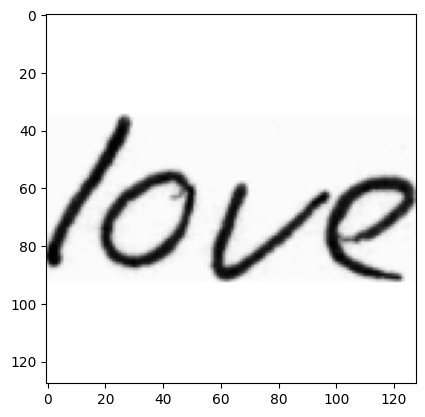

In [5]:
torch.set_printoptions(linewidth=200, precision=4, edgeitems=200, sci_mode=False)
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    # print(img.min(), img.max(), img.mean())
    output, probability = model.forward_beam(img)
    # 只取第一个样本
    output = output[0]
    probability = probability[0]
    print("answer: ", get_word(label[0]))
    for i in range(10):
        print("predict:", get_word(output[i]), "\tprobability:", round(probability[i].item(), 4))
    img = img[0]
    # print(img.min().item(), img.max().item(), img.mean().item())
    
    show_img(img)
    plt.show()
    break

torch.Size([2, 1, 128, 128])
['had', 'hed', 'hod', 'hadd', 'head', 'haded', 'hald', 'Lad', 'hade', 'hode', 'hads', 'hedd', 'hodd', 'lad', 'heal', 'hoved', 'hadel', 'hove', 'hock', 'hoch', 'hocl', 'kad', 'hal', 'hard', 'tad', 'bad', 'hach', 'hoal', 'Lod', 'tod', 'hoct', 'hasd', 'lade', 'hady', 'lord', 'hoad', 'Led', 'hoda', 'hadl', 'hadal', 'hadid', 'rad', 'Ladel', 'hond', 'had-', 'hid', 'heala', 'nad', 'led', 'hocd', "had'd", 'had0', 'Laded', 'hox', 'hovel', 'hedal', 'hax', 'has', 'have', 'red', 'hea', 'lod', 'har', 'hoed', 'hect', 'hover', 'hall', 'hood', 'hoc', 'tred', 'hodil', 'heck', 'ted', 'heak', 'hody', 'todal', 'hov', 'hadet', 'hack', 'hovela', 'hated', 'hand', 'hasl', 'nod', 'hash', 'how', 'hoced', 'thd', 'loul', 'hask', 'hecl', 'hech', 'ladd', 'fad', 'bed', 'tral', 'Rad', 'hab', 'houd', 'rod', 'hos', 'hoder', 'hado', 'halla', 'hact', 'hacla', 'hast', 'ned', 'loud', 'hex', 'had.', 'hovelo', 'hoce', 'hag', 'hac', 'hud', 'Lacal', 'hods', 'howed', 'hovele', 'hale', 'Ladd', 'Lader

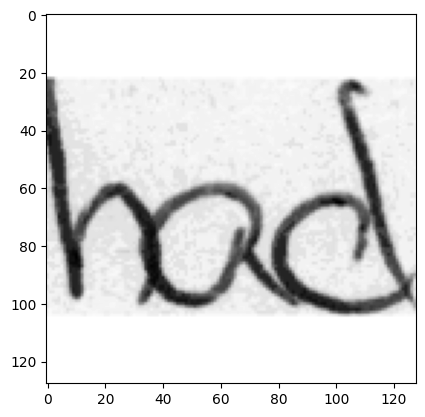

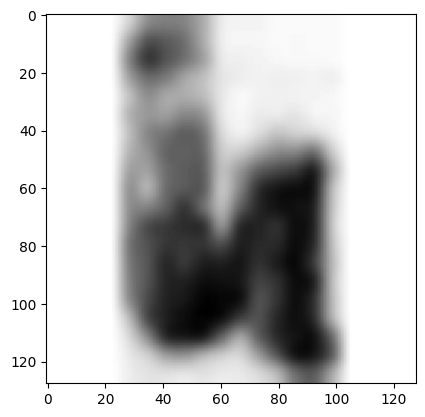

In [6]:
# 使用CRNN自带的to_words函数
for step, (img, label) in enumerate(dataloader):
    img, label = img.to("cuda:0"), label.to("cuda:0")
    print(img.shape)
    output, probability = model.forward_beam(img)
    words_pred = model.beam_output_to_words(output)
    for words in words_pred:
        print(words)
    for img in img:
        show_img(img)
    break

测试模型在测试数据集上的表现

In [7]:
def get_test_loss(model, dataloader, device):
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    loss = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            h_n, c_n = model.init_state(img)
            h_n, c_n = h_n.to(device), c_n.to(device)
            output = torch.zeros(target.shape[0], model.max_len, model.num_classes).to(device)
            x = target[:, 0]
            output[:, 0] = x
            x = model.embedding(x.long().unsqueeze(1))
            for i in range(model.max_len-1):
                x = model.embedding(target[:, i].argmax(-1).unsqueeze(1))
                x, (h_n, c_n) = model.next_char(x, (h_n, c_n))
                output[:, i+1] = x.squeeze(1)
            loss += criterion(output.view(-1, model.num_classes), target.argmax(-1).view(-1))
    return loss / len(dataloader)

# # test loss
# dataset = RecDataset("IAM", "test")
# dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
# get_test_loss(model, dataloader, "cuda:0")

测试模型在测试集上的精度（完全正确数/总数）

In [1]:
def get_accuracy(model, dataloader, device, top_n=1):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for step, (img, target) in enumerate(dataloader):
            img, target = img.to(device), target.to(device)
            output, probability = model.forward_beam(img)
            words_pred = model.beam_output_to_words(output)
            words_pred = [words[0] for words in words_pred]
            words_target = model.output_to_words(target)
            for i in range(len(words_pred)):
                if words_pred[i] == words_target[i]:
                    correct += 1
                total += 1
            print(f"\r{correct}/{total}={correct/total: .4f}", end='')
    return correct / total

# test accuracy
from utils import *
from CRNN import *
from torch.utils.data import DataLoader
model = CRNN()
model_name = get_model_name(33, "Aug")
model_path = "../Machine_Learning_Output/CRNN/"
model.load_state_dict(torch.load(model_path + model_name, weights_only=True))
model.to("cuda:0")
model.eval()

dataset = RecDataset("IAM", "test")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
accuracy = get_accuracy(model, dataloader, "cuda:0")
print(f"\raccuracy: {accuracy}")

3134/3968= 0.7898

KeyboardInterrupt: 